In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error

df = pd.read_csv("global_economy.csv")

In [3]:
# Assuming 'Year' is already in int64 format
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')

# Filter the data for Brazil
df = df[df['Country'] == 'Brazil']

In [4]:
# Step 2: Train/Test Split
split_year = pd.to_datetime('2012')
train = df.loc[df.index < split_year]
test = df.loc[df.index >= split_year]

# Check for missing values in the target variable 'GDP'
if train['GDP'].isnull().any() or test['GDP'].isnull().any():
    raise ValueError("Target variable 'GDP' contains missing values.")


In [5]:

# Step 3: Feature Creation (if needed)
# No additional features are needed for yearly data.

# Step 4: Model Training
FEATURES = ['Growth', 'CPI', 'Imports', 'Exports', 'Population']
TARGET = 'GDP'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(
    n_estimators=100,  # Set the number of boosting rounds
    learning_rate=0.1,  # Set the learning rate
    max_depth=3,  # Set the maximum depth of each tree
    random_state=42  # Set a random seed for reproducibility
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)


[0]	validation_0-rmse:680240901270.04468	validation_1-rmse:2044088754838.89014
[99]	validation_0-rmse:10365577795.55299	validation_1-rmse:514425416373.72009


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [6]:
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create Grid Search object
grid_search = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

<ipython-input-7-ebaa55e77e8f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = best_model.predict(X_test)


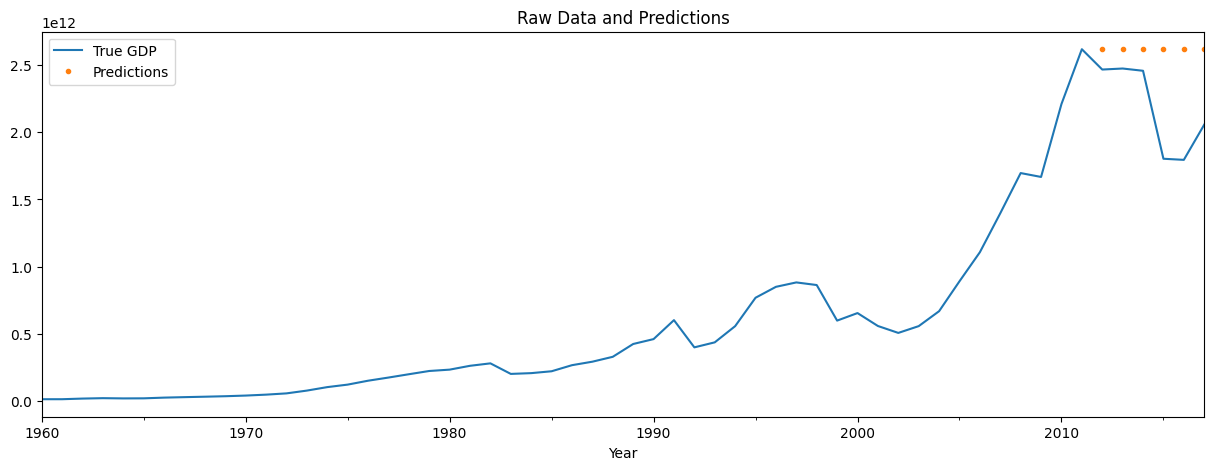

In [7]:
# Step 5: Feature Importance (if needed)
# No feature importance analysis is needed for this example.

# Step 6: Forecast and Visualization with the best model
test['prediction'] = best_model.predict(X_test)
merged_df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = merged_df[['GDP']].plot(figsize=(15, 5))
merged_df['prediction'].plot(ax=ax, style='.')
plt.legend(['True GDP', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score


# Step 7: Evaluation with cross-validated RMSE score
cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_score = np.sqrt(-cv_score.mean())

print(f'RMSE Score on Test set: {np.sqrt(mean_squared_error(test["GDP"], test["prediction"])):0.2f}')
print(f'Cross-validated RMSE Score on Train set: {cv_rmse_score:0.2f}')

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

RMSE Score on Test set: 534468335945.00
Cross-validated RMSE Score on Train set: 466155434622.14
Best Hyperparameters:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}
